<a href="https://colab.research.google.com/github/blackBagel/flu-shots/blob/main/Flu_shot_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
# from __future__ import print_function
import pandas as pd
import numpy as np
import os
from google.colab import drive
from tqdm import tqdm
# from joblib import Parallel, delayed
# import re
import math
# from currency_converter import CurrencyConverter

from sklearn.impute import SimpleImputer
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
# from category_encoders import CountEncoder
from sklearn.model_selection import train_test_split
# from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# import eli5
import pickle
from time import perf_counter
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
DRIVE_PATH = '/gdrive/My Drive/Data_Projects/Flu_Shots'
drive.mount('/gdrive')
os.chdir(DRIVE_PATH)
!ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
submission_format.csv  training_set_features.csv
test_set_features.csv  training_set_labels.csv


In [114]:
full_train_df = pd.read_csv("training_set_features.csv")
full_train_labels = pd.read_csv("training_set_labels.csv")

In [115]:
full_train_df

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg


In [116]:
full_train_labels

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


In [117]:
full_train_df = full_train_df.set_index("respondent_id")
full_train_labels = full_train_labels.set_index("respondent_id")

# Checking if there are inconcistency issues in the data
(full_train_df.index != full_train_labels.index).sum()

0

In [118]:
full_train_labels

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0
...,...,...
26702,0,0
26703,0,0
26704,0,1


#### Train validation split

In [119]:
# Checking how many observations in test set
! wc -l "test_set_features.csv"

26709 test_set_features.csv


Unfortunately, the test set is the same size as the train set.  
So since i can't create a validation set as big, i'll just take a small fraction of the train set for validation

In [120]:
TRAIN_VAL_RAND_STATE = 1
TRAIN_VAL_SPLIT = 0.2

# We use the same train-test split to test all of the models
df_train, df_val, labels_train, labels_val = train_test_split(full_train_df,
                                                              full_train_labels,
                                                              random_state=TRAIN_VAL_RAND_STATE,
                                                              test_size=TRAIN_VAL_SPLIT,
                                                              shuffle=True)

print(f"train size: {len(df_train)}")
print(f"val size: {len(df_val)}")
print(f"train labels size: {len(labels_train)}")
print(f"val labels size: {len(labels_val)}")

train size: 21365
val size: 5342
train labels size: 21365
val labels size: 5342


# H1N1 shots
I want to handle each problem orthonogically. After I'll feel I know enough about H1N1 predictions, I'll start working on improving flu shot scores as well.

In [121]:
def describe_columns(df):
  TOO_MANY_NULLS_PERCENT = 0.01
  columns_with_lots_of_nulls = []

  print(f"The df has {df.shape[1]} columns")
  print("Column name                  | dtype   | Amount of nulls")
  print("--------------------------------------------------------")
  for column in df.columns:
    num_of_nulls = df[column].isnull().sum()
    col_dtype = str(df.dtypes[column])
    print(f"{column:<28} | {col_dtype:<7} | {num_of_nulls}")

    if num_of_nulls > len(df_train) * TOO_MANY_NULLS_PERCENT:
      columns_with_lots_of_nulls.append(column)

  print()
  print(f"Columns that have more than {TOO_MANY_NULLS_PERCENT * 100}% null values:")
  print(columns_with_lots_of_nulls)

describe_columns(df_train)

The df has 35 columns
Column name                  | dtype   | Amount of nulls
--------------------------------------------------------
h1n1_concern                 | float64 | 75
h1n1_knowledge               | float64 | 87
behavioral_antiviral_meds    | float64 | 56
behavioral_avoidance         | float64 | 178
behavioral_face_mask         | float64 | 14
behavioral_wash_hands        | float64 | 32
behavioral_large_gatherings  | float64 | 68
behavioral_outside_home      | float64 | 66
behavioral_touch_face        | float64 | 97
doctor_recc_h1n1             | float64 | 1729
doctor_recc_seasonal         | float64 | 1729
chronic_med_condition        | float64 | 792
child_under_6_months         | float64 | 665
health_worker                | float64 | 650
health_insurance             | float64 | 9829
opinion_h1n1_vacc_effective  | float64 | 327
opinion_h1n1_risk            | float64 | 322
opinion_h1n1_sick_from_vacc  | float64 | 326
opinion_seas_vacc_effective  | float64 | 381
opinion_seas_r

### Handling nulls

In [123]:
columns_with_type_float = df_train.select_dtypes(include=['float64']).columns.tolist()
columns_with_type_string = df_train.select_dtypes(include=['object']).columns.tolist()

#### Float64 Features 

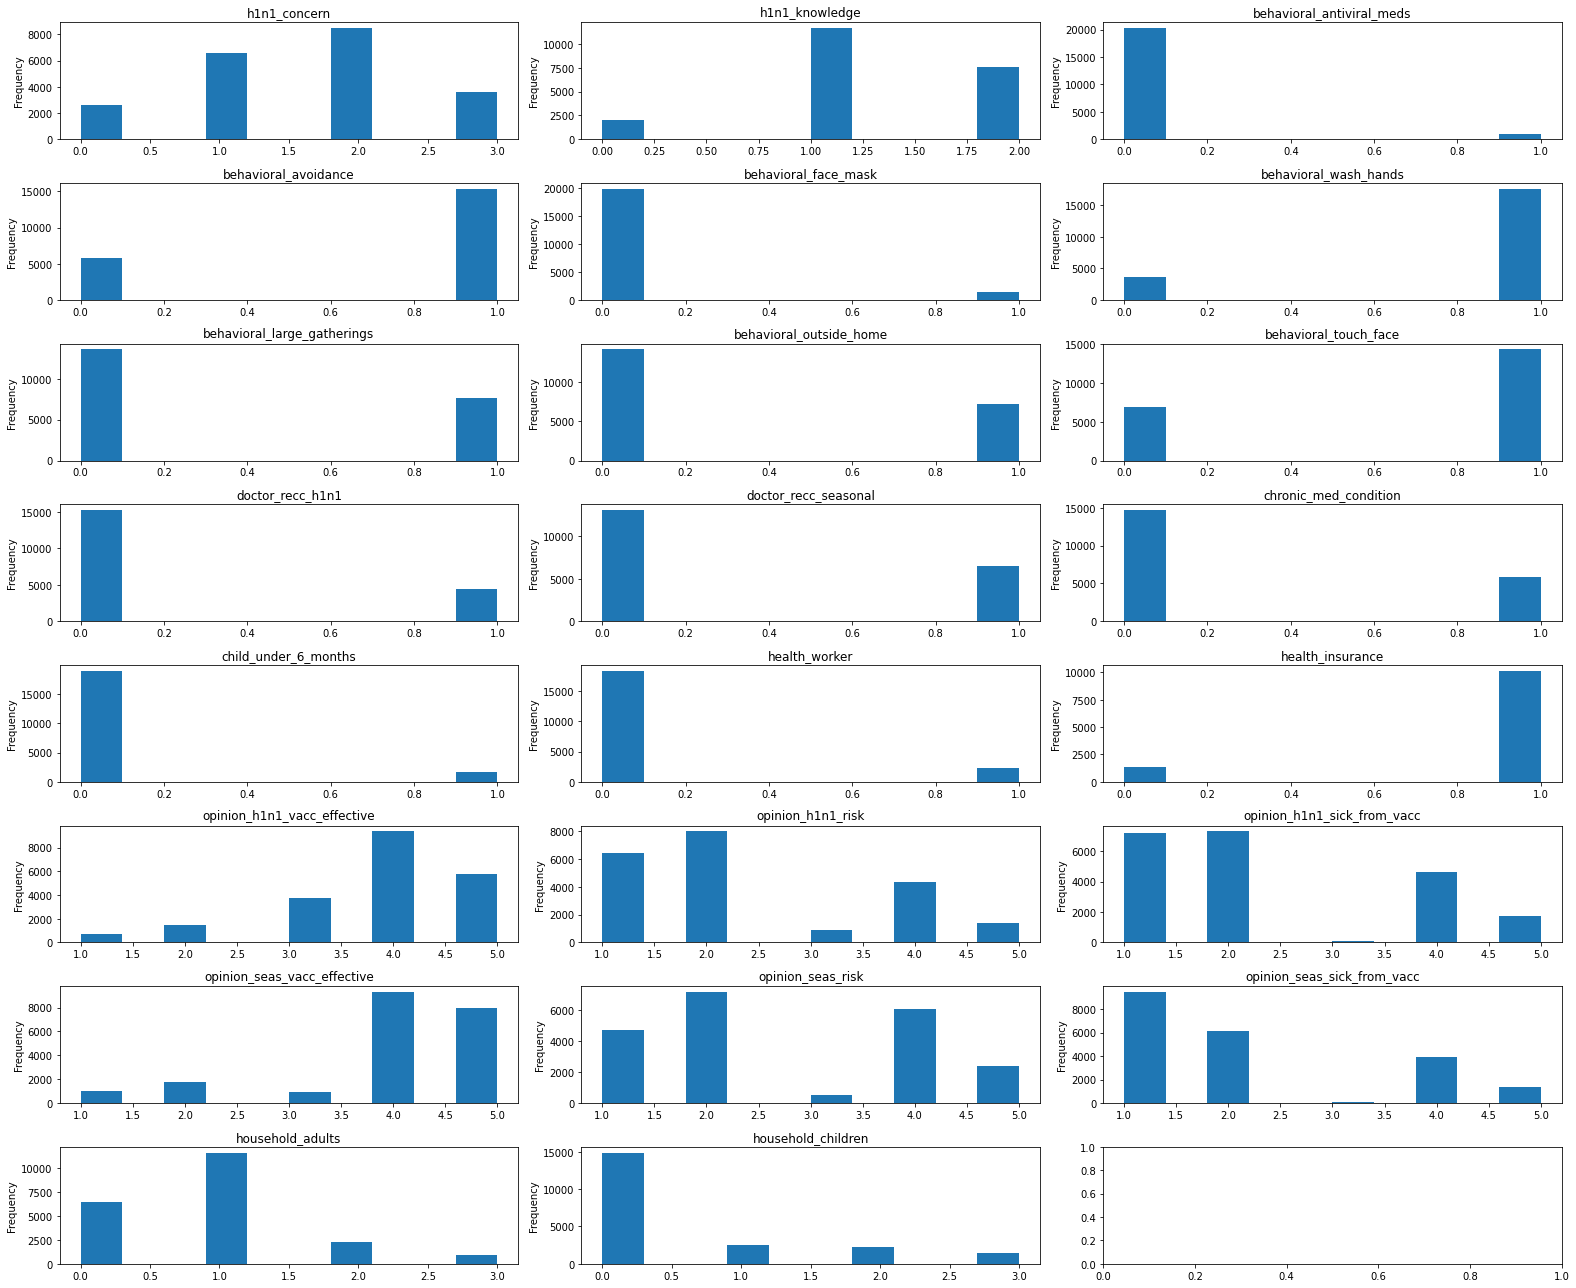

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=8, figsize=(22,18))
axes_list = [item for sublist in axes for item in sublist] 

# plot every month's daily count of transactions
for column in tqdm(columns_with_type_float):
  ax = axes_list.pop(0)
  df_train[column].plot(kind='hist', ax=ax)
  ax.set_title(column)

fig.tight_layout()

In [ ]:
# columns_that_can_have_better_impute = ['doctor_recc_h1n1', # X
#                                        'doctor_recc_seasonal', # X
#                                        'health_insurance', # V
#                                        'education', # 
#                                        'income_poverty',
#                                        'marital_status',
#                                        'rent_or_own',
#                                        'employment_status', 
#                                        'employment_industry',
#                                        'employment_occupation']


#### String Categorical Features

100%|██████████| 12/12 [00:00<00:00, 45.90it/s]


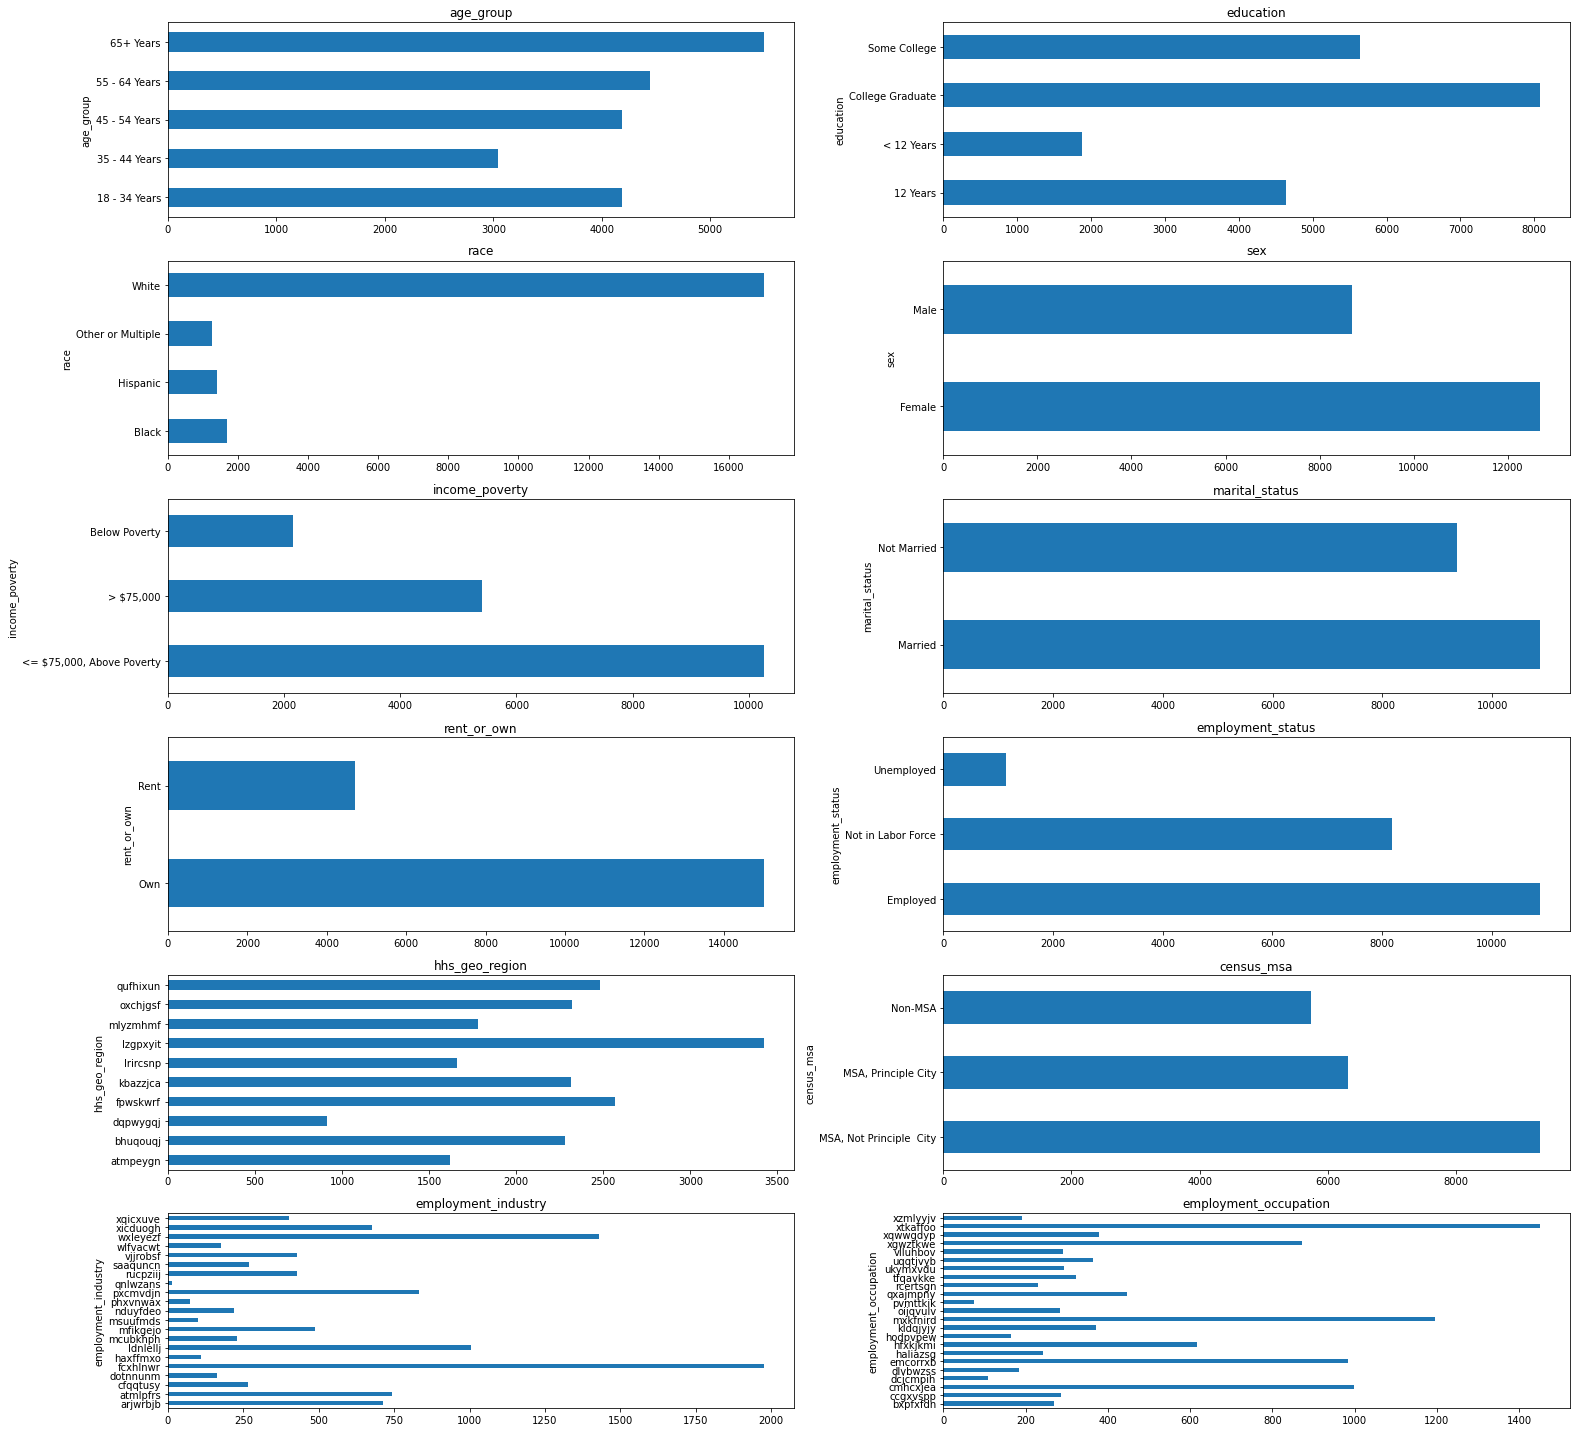

In [ ]:
PLOTS_PER_ROW = 2
n_rows = math.ceil(len(columns_with_type_string) / PLOTS_PER_ROW)
fig, axes = plt.subplots(ncols=PLOTS_PER_ROW, nrows=n_rows, figsize=(22,20))
axes_list = [column for row in axes for column in row] 

# plot every feature's frequency of each value
for column in tqdm(columns_with_type_string):
  ax = axes_list.pop(0)
  df_train.groupby(column).size().plot(kind='barh', title=column, ax=ax)

fig.tight_layout()

# full_risk_df.groupby().size().plot(kind='bar', title='Transactions per month', figsize=(8,6))

Since I don't want to start fiddling with Advanced imputation techniques, for now I'll only impute `race` and `rent_or_own` using the most frequent value, and all the rest of the features will simply have a literal string `NaN` where empty so I could still get some sense of which features are useful for this classification

In [ ]:
string_features_for_mf_impute = { 'race', 'rent_or_own' }
string_features_for_placeholder_impute = set(columns_with_type_string) - string_features_for_mf_impute
string_features_to_classify_by = string_features_for_mf_impute | string_features_for_placeholder_impute

#### Imputation

In [ ]:
features_to_not_impute = {'respondent_id'}

In [ ]:
float_features_for_placeholder_impute = {'doctor_recc_h1n1', 'doctor_recc_seasonal'}
float_features_for_mf_impute = set(df_train.select_dtypes(include=['float64']).columns) - float_features_for_placeholder_impute - features_to_not_impute
float_features_to_classify_by = float_features_for_mf_impute | float_features_for_placeholder_impute

In [ ]:
FEATURES_TO_CLASSIFY_BY = float_features_to_classify_by | string_features_to_classify_by
df_train_for_clf = df_train[FEATURES_TO_CLASSIFY_BY]

In [ ]:
df_train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22542,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,4.0,5.0,2.0,4.0,18 - 34 Years,NaN,White,Female,NaN,NaN,NaN,NaN,oxchjgsf,Non-MSA,3.0,1.0,NaN,NaN
15778,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5.0,2.0,2.0,5.0,4.0,2.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,mlyzmhmf,"MSA, Principle City",0.0,1.0,NaN,NaN
15152,3.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,2.0,5.0,5.0,2.0,35 - 44 Years,12 Years,Black,Male,Below Poverty,Not Married,Rent,NaN,fpwskwrf,"MSA, Principle City",1.0,0.0,NaN,NaN
14690,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,4.0,1.0,2.0,4.0,2.0,1.0,35 - 44 Years,College Graduate,Black,Female,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,Non-MSA,0.0,0.0,fcxhlnwr,bxpfxfdn
13249,3.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,2.0,2.0,1.0,2.0,35 - 44 Years,12 Years,White,Female,NaN,Not Married,Rent,Not in Labor Force,fpwskwrf,"MSA, Not Principle City",0.0,0.0,NaN,NaN


In [ ]:
features_for_mf_impute = list(float_features_for_mf_impute | string_features_for_mf_impute)
features_for_placeholder_impute = list(float_features_for_placeholder_impute | string_features_for_placeholder_impute)
most_freq_imputer = SimpleImputer(strategy='most_frequent')
placeholder_imputer = SimpleImputer(strategy='constant', fill_value='NaN')

data_preparation_imputer = ColumnTransformer([
                                              ('mf', most_freq_imputer, features_for_mf_impute),
                                              ('nan', placeholder_imputer, features_for_placeholder_impute)
])

data_preparation_pipeline = Pipeline([('Impute', data_preparation_imputer)])

In [ ]:
columns_after_processing = [column for _,_,columns in data_preparation_imputer.transformers_ for column in columns]
columns_after_processing

['opinion_h1n1_risk',
 'opinion_h1n1_vacc_effective',
 'behavioral_large_gatherings',
 'household_children',
 'behavioral_touch_face',
 'health_insurance',
 'opinion_h1n1_sick_from_vacc',
 'behavioral_outside_home',
 'opinion_seas_risk',
 'rent_or_own',
 'opinion_seas_sick_from_vacc',
 'behavioral_antiviral_meds',
 'child_under_6_months',
 'behavioral_wash_hands',
 'behavioral_face_mask',
 'race',
 'opinion_seas_vacc_effective',
 'household_adults',
 'chronic_med_condition',
 'h1n1_knowledge',
 'h1n1_concern',
 'behavioral_avoidance',
 'health_worker',
 'age_group',
 'sex',
 'employment_status',
 'education',
 'census_msa',
 'income_poverty',
 'marital_status',
 'hhs_geo_region',
 'doctor_recc_h1n1',
 'employment_occupation',
 'employment_industry',
 'doctor_recc_seasonal']

In [ ]:
df_train_processed = data_preparation_imputer.fit_transform(df_train_for_clf)

df_train_processed = pd.DataFrame(df_train_processed,
                                  columns = columns_after_processing,
                                  index=df_train_for_clf.index)

,opinion_h1n1_risk,opinion_h1n1_vacc_effective,behavioral_large_gatherings,household_children,behavioral_touch_face,health_insurance,opinion_h1n1_sick_from_vacc,behavioral_outside_home,opinion_seas_risk,rent_or_own,opinion_seas_sick_from_vacc,behavioral_antiviral_meds,child_under_6_months,behavioral_wash_hands,behavioral_face_mask,race,opinion_seas_vacc_effective,household_adults,chronic_med_condition,h1n1_knowledge,h1n1_concern,behavioral_avoidance,health_worker,age_group,sex,employment_status,education,census_msa,income_poverty,marital_status,hhs_geo_region,doctor_recc_h1n1,employment_occupation,employment_industry,doctor_recc_seasonal
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22542,4,4,0,1,1,1,4,0,2,Own,4,0,0,1,0,White,5,3,0,1,1,1,0,18 - 34 Years,Female,NaN,NaN,Non-MSA,NaN,NaN,oxchjgsf,0,NaN,NaN,0
15778,2,5,0,1,0,1,2,0,4,Own,2,0,0,1,0,White,5,0,1,2,1,0,0,45 - 54 Years,Female,Not in Labor Force,Some College,"MSA, Principle City","<= $75,000, Above Poverty",Not Married,mlyzmhmf,0,NaN,NaN,0
15152,2,5,1,0,1,1,2,1,5,Rent,2,0,0,1,0,Black,5,1,0,0,3,1,0,35 - 44 Years,Male,NaN,12 Years,"MSA, Principle City",Below Poverty,Not Married,fpwskwrf,0,NaN,NaN,1
14690,1,4,0,0,1,1,2,0,2,Rent,1,0,0,1,0,Black,4,0,0,1,2,1,0,35 - 44 Years,Female,Employed,College Graduate,Non-MSA,"<= $75,000, Above Poverty",Not Married,lzgpxyit,0,bxpfxfdn,fcxhlnwr,1
13249,2,3,1,0,0,1,2,0,1,Rent,2,0,0,1,0,White,2,0,0,1,3,1,0,35 - 44 Years,Female,Not in Labor Force,12 Years,"MSA, Not Principle City",NaN,Not Married,fpwskwrf,0,NaN,NaN,0


Making sure i assigned the correct columns to the transformed df  
And that I imputed the columns as intended 

In [ ]:
def compare_df_row_changes(df_from, df_to):
  '''
    Expects DFs with identical ids and column order!
  '''
  df1 = df_from.copy()
  df2 = df_to.copy()

  ne_stacked = (df1 != df2).stack()
  changed = ne_stacked[ne_stacked]
  changed.index.names = ['id', 'column']

  difference_locations = np.where(df1 != df2)

  changed_from = df1.values[difference_locations]
  changed_to = df2.values[difference_locations]

  print(pd.DataFrame({'from': changed_from, 'to': changed_to}, index=changed.index))

df1 = df_train[columns_after_processing].iloc[[0,1], :]
df2 = df_train_processed.iloc[[0,1], :]
compare_df_row_changes(df1, df2)

                            from   to
id    column                         
22542 health_insurance       NaN    1
      rent_or_own            NaN  Own
      employment_status      NaN  NaN
      education              NaN  NaN
      income_poverty         NaN  NaN
      marital_status         NaN  NaN
      employment_occupation  NaN  NaN
      employment_industry    NaN  NaN
15778 employment_occupation  NaN  NaN
      employment_industry    NaN  NaN


### Encoding string columns

##############################################  
TBD: Handle bad NaNs with advanced imputers 
##############################################

In [53]:
for feature in columns_with_string_value:
  print(f'{feature}\'s Cardinality is {df_train[feature].nunique()}')

age_group's Cardinality is 5
education's Cardinality is 4
race's Cardinality is 4
sex's Cardinality is 2
income_poverty's Cardinality is 3
marital_status's Cardinality is 2
rent_or_own's Cardinality is 2
employment_status's Cardinality is 3
hhs_geo_region's Cardinality is 10
census_msa's Cardinality is 3
employment_industry's Cardinality is 21
employment_occupation's Cardinality is 23


##############################################  
TBD: Handle bad NaNs with advanced imputers 
##############################################

In [54]:
print(f"\n hhs_geo_region has the following possible values: {df_train['hhs_geo_region'].unique()}")
print(f"\n employment_industry has the following possible values: {df_train['employment_industry'].unique()}")
print(f"\n employment_occupation has the following possible values: {df_train['employment_occupation'].unique()}")
print(f"\n employment_status has the following possible values: {df_train['employment_status'].unique()}")
print(f"\n education has the following possible values: {df_train['education'].unique()}")
print(f"\n age_group has the following possible values: {df_train['age_group'].unique()}")


 hhs_geo_region has the following possible values: ['oxchjgsf' 'mlyzmhmf' 'fpwskwrf' 'lzgpxyit' 'kbazzjca' 'qufhixun'
 'atmpeygn' 'bhuqouqj' 'lrircsnp' 'dqpwygqj']

 employment_industry has the following possible values: [nan 'fcxhlnwr' 'saaquncn' 'ldnlellj' 'dotnnunm' 'phxvnwax' 'arjwrbjb'
 'xqicxuve' 'atmlpfrs' 'msuufmds' 'haxffmxo' 'pxcmvdjn' 'wlfvacwt'
 'cfqqtusy' 'vjjrobsf' 'wxleyezf' 'xicduogh' 'mcubkhph' 'rucpziij'
 'mfikgejo' 'nduyfdeo' 'qnlwzans']

 employment_occupation has the following possible values: [nan 'bxpfxfdn' 'mxkfnird' 'hfxkjkmi' 'cmhcxjea' 'kldqjyjy' 'qxajmpny'
 'dlvbwzss' 'tfqavkke' 'xqwwgdyp' 'dcjcmpih' 'xtkaffoo' 'xgwztkwe'
 'oijqvulv' 'hodpvpew' 'emcorrxb' 'vlluhbov' 'rcertsgn' 'xzmlyyjv'
 'ccgxvspp' 'ukymxvdu' 'uqqtjvyb' 'haliazsg' 'pvmttkik']

 employment_status has the following possible values: [nan 'Not in Labor Force' 'Employed' 'Unemployed']

 education has the following possible values: [nan 'Some College' '12 Years' 'College Graduate' '< 12 Years']


In [55]:
columns_for_OH_encoding = [feature for feature in columns_with_string_value if df_train[feature].nunique() <= 5]
# columns_for_OH_encoding = columns_for_OH_encoding - ['age_group', 'education', 'employment_status']

# columns_for_ord_encoding = columns_with_string_value[~ .isin(columns_for_OH_encoding)]
# columns_for_num_encoding = list(columns_for_num_encoding)

### Selecting Best Features

In [109]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

fs = SelectKBest(score_func=chi2, k='all')
fs.fit(df_train_processed, labels_train['h1n1_vaccine'])

columns = list(df_train_for_clf.columns)
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (columns[i], fs.scores_[i]))

# plot the scores
plt.figure(figsize=(12,10))
plt.barh(y=[columns[i] for i in range(len(fs.scores_))], width=fs.scores_)
plt.show()

ValueError: ignored

In [ ]:
# Only here to show the graph above is correct with column assigments
fs_top_4 = SelectKBest(score_func=chi2, k=4)

fs_top_4.fit(df_train_processed, labels_train['h1n1_vaccine'])
cols_to_keep = fs_top_4.get_support(indices=True)
features_df_new = df_train_for_clf.iloc[:,cols_to_keep]
features_df_new.columns

Index(['health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_seas_risk'],
      dtype='object')

Feature h1n1_concern: 0.010211
Feature h1n1_knowledge: 0.008445
Feature behavioral_antiviral_meds: 0.000000
Feature behavioral_avoidance: 0.007642
Feature behavioral_face_mask: 0.002358
Feature behavioral_wash_hands: 0.006957
Feature behavioral_large_gatherings: 0.001943
Feature behavioral_outside_home: 0.001529
Feature behavioral_touch_face: 0.002119
Feature chronic_med_condition: 0.003103
Feature child_under_6_months: 0.005932
Feature health_worker: 0.011221
Feature health_insurance: 0.004435
Feature opinion_h1n1_vacc_effective: 0.047777
Feature opinion_h1n1_risk: 0.050310
Feature opinion_h1n1_sick_from_vacc: 0.006087
Feature opinion_seas_vacc_effective: 0.025966
Feature opinion_seas_risk: 0.034982
Feature opinion_seas_sick_from_vacc: 0.000000
Feature household_adults: 0.004599
Feature household_children: 0.000000


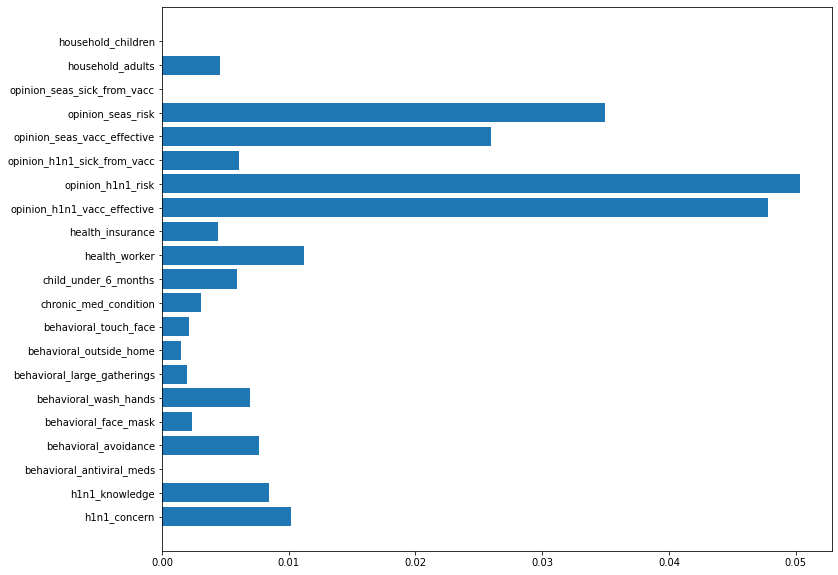

In [ ]:
from sklearn.feature_selection import mutual_info_classif

fs = SelectKBest(score_func=mutual_info_classif, k='all')

# df_train_processed = data_preparation_pipeline.fit_transform(df_train_for_clf)
fs.fit(df_train_processed, labels_train['h1n1_vaccine'])

columns = list(df_train_for_clf.columns)
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (columns[i], fs.scores_[i]))

# plot the scores
plt.figure(figsize=(12,10))
plt.barh(y=[columns[i] for i in range(len(fs.scores_))], width=fs.scores_)
plt.show()